In [1]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Initialize the wandb API
api = wandb.Api()

# Define the project and entity
entity = "L65_Project"
project = "transformer-graph-learner"

# Fetch all runs for the project
runs = api.runs(f"{entity}/{project}")
print("Fetching runs...")

# List to store filtered run data
data_points = []

for run in runs:
    # Filter for the specific group
    if run.group != "intermediate-supervision-test":
        continue

    config = run.config

    # Filter runs: only include runs with dataset n_nodes_range [8, 8]
    if config.get('dataset', {}).get('n_nodes_range', None) != [8, 8]:
        continue

    # Filter runs: model.intermediate_supervision must be False
    supervision = config.get('model', {}).get('intermediate_supervision', None)
    if supervision is None:
        continue

    # Ensure a seed exists (indicating different runs)
    seed = config.get('seed', None)
    if seed is None:
        continue

    # Get nhead (number of heads) from the model configuration
    nhead = config.get('model', {}).get('nhead', None)
    if nhead is None:
        continue

    # Fetch test_loss history
    test_loss_df = run.history(keys=["test_loss"])
    if "test_loss" not in test_loss_df.columns:
        continue

    # Calculate the minimum test loss for the run (across all epochs)
    best_test_loss = np.min(test_loss_df["test_loss"])

    # Get eccentricity from the dataset configuration (ensure it exists)
    eccentricity = config.get('dataset', {}).get('eccentricity', None)
    if eccentricity is None:
        continue

    # Get the number of layers for grouping within the graph
    num_layers = config.get('model', {}).get('num_layers', None)
    if num_layers is None:
        continue

    data_points.append({
        "eccentricity": eccentricity,
        "best_test_loss": best_test_loss,
        "num_layers": num_layers,
        "nhead": nhead,
        "seed": seed,
        "intermediate_supervision": supervision
    })

Fetching runs...


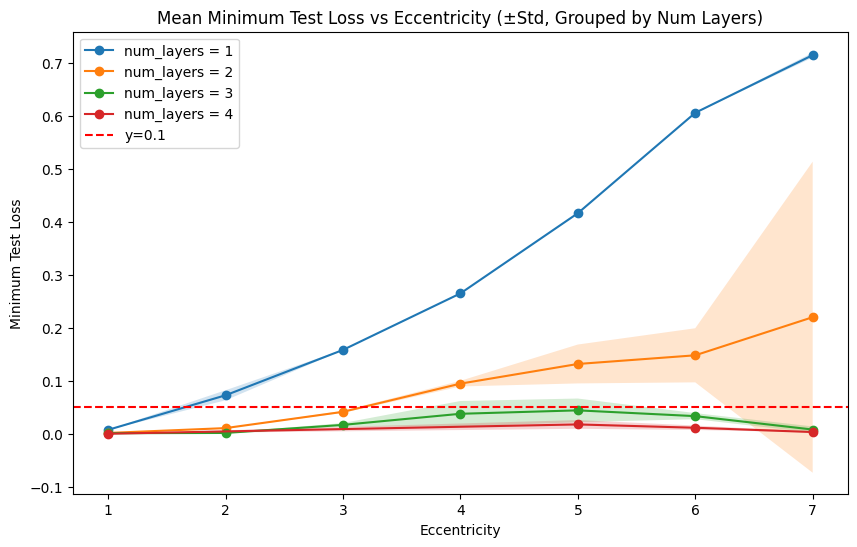

In [21]:
# Convert collected data to a pandas DataFrame
df = pd.DataFrame(data_points)

df = df[
    (df["intermediate_supervision"] == False) &
    (df["nhead"] == 1) &
    (df["num_layers"] <= 4)
]
grouped = df.groupby(["num_layers", "eccentricity"]).agg(
    mean_test_loss=("best_test_loss", "mean"),
    std_test_loss=("best_test_loss", "std")
).reset_index()

# Plotting: for each unique num_layers, plot a line with error bands representing std deviation
plt.figure(figsize=(10, 6))
unique_layers = grouped["num_layers"].unique()

for nl in unique_layers:
    # Filter data for the specific number of layers
    data_nl = grouped[grouped["num_layers"] == nl]
    # Sort the data by eccentricity for a smoother line
    data_nl = data_nl.sort_values("eccentricity")
    x = data_nl["eccentricity"]
    y = data_nl["mean_test_loss"]
    yerr = data_nl["std_test_loss"]

    plt.plot(x, y, marker='o', label=f'num_layers = {nl}')
    plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

# draw horizontal line
plt.axhline(y=0.05, color='r', linestyle='--', label='y=0.1')

plt.xlabel('Eccentricity')
plt.ylabel('Minimum Test Loss')
plt.title('Mean Minimum Test Loss vs Eccentricity (±Std, Grouped by Num Layers)')
plt.legend()
plt.show()
